## Project of Pattern Recognition

# Import require library

In [16]:
# Face datasets from sklearn
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV

# Data visualization tool
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# ndarray
import numpy as np

# skimage for image processing
from sklearn.decomposition import PCA
from skimage import exposure, feature

# For measure time cost
from time import time

# Classification report
from sklearn.metrics import accuracy_score

# Data Collection
Gether the face data sets from scikit-learn build-in datasets.

In [17]:
ori_faces = fetch_lfw_people(min_faces_per_person=50)

n_sample, h, w = ori_faces.images.shape
n_features = ori_faces.data.shape[1]
data_shape = ori_faces.data.shape
target_names = ori_faces.target_names
n_classes = len(target_names)

print('Total number of sample: {}'.format(n_sample))
print('Image size: {} x {}'.format(h, w))
print("Total features per IMG: {}".format(n_features))
print("DataFrame shape: {}".format(data_shape))
print('Target names: {}'.format(target_names))
print('Total classes: {}'.format(n_classes))

Total number of sample: 1560
Image size: 62 x 47
Total features per IMG: 2914
DataFrame shape: (1560, 2914)
Target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']
Total classes: 12


Done in: 0.650s


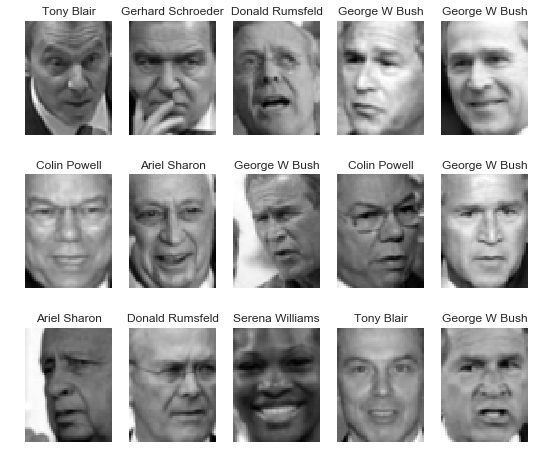

In [18]:
st_time = time()

fig, ax = plt.subplots(3, 5, figsize=(9, 8))

for i, axi in enumerate(ax.flat):
    axi.imshow(ori_faces.images[i], cmap='gray')
    axi.set_title(ori_faces.target_names[ori_faces.target[i]])
    axi.axis('off')

print('Done in: {:0.3f}s'.format(time()-st_time))

# Split datasets into Train & Test

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    ori_faces.data, 
    ori_faces.target,
    random_state=42 # random_state is the seed used by the random number generator
)

We want to choose min pca component, from the plot we can see the range.

# HOG Feature Extraction

/Users/AlexChen/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Done in: 12.401s


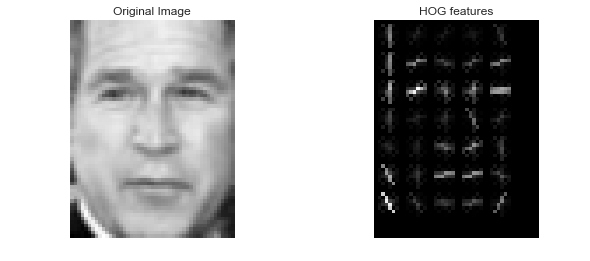

In [20]:
st_time = time()

X_train_hog = np.zeros(X_train.shape)
X_test_hog = np.zeros(X_test.shape)

for i in range(X_train.shape[0]):
    hog_vec, hog_vis = feature.hog(X_train[i].reshape(h,w), visualise=True)
    X_train_hog[i] = hog_vis.flat
for i in range(X_test.shape[0]):
    hog_vec, hog_vis = feature.hog(X_test[i].reshape(h,w), visualise=True)
    X_test_hog[i] = hog_vis.flat

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].imshow(X_train[0].reshape(h,w), cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(X_train_hog[0].reshape(h,w), cmap='gray')
ax[1].set_title('HOG features')
ax[1].axis('off')

print('Done in: {:0.3f}s'.format(time()-st_time))

# PCA Feature Extraction

Done in: 0.717s


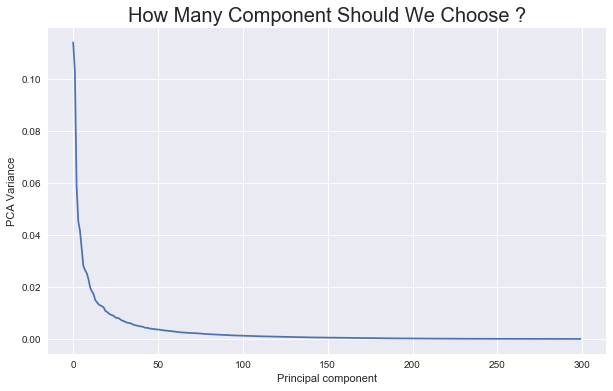

In [21]:
st_time = time()

pca = PCA(n_components=300, svd_solver='randomized', whiten=True).fit(X_train_hog)

plt.figure(figsize=(10,6))
plt.plot(pca.explained_variance_ / sum(pca.explained_variance_))
plt.xlabel('Principal component')
plt.ylabel('PCA Variance')
plt.title('How Many Component Should We Choose ?', fontsize=20)
plt.grid(True)

print('Done in: {:0.3f}s'.format(time()-st_time))

In [23]:
st_time = time()

n_components = 200

print("Extracting the top {} component from HOG train set of {} faces.".format(n_components, X_train_hog.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train_hog)
eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train_hog)
X_test_pca = pca.transform(X_test_hog)

print('Done in: {:0.3f}s'.format(time()-st_time))

Extracting the top 200 component from HOG train set of 1170 faces.
Done in: 0.500s


Done in: 0.093s


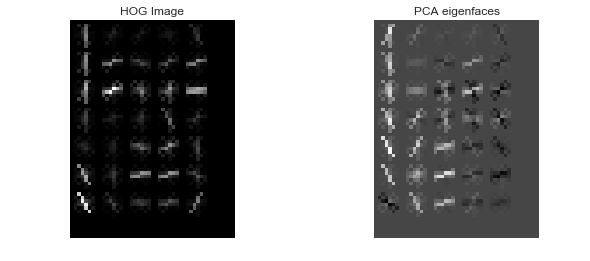

In [25]:
st_time = time()

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].imshow(X_train_hog[0].reshape(h,w), cmap='gray')
ax[0].set_title('HOG Image')
ax[0].axis('off')

ax[1].imshow(eigenfaces[0], cmap='gray')
ax[1].set_title('PCA eigenfaces')
ax[1].axis('off')

print('Done in: {:0.3f}s'.format(time()-st_time))

C is the penalty error that governs to what degree the model is allowed to misclassify As C approaches infinity, the model approaches standalone state When C is small, the model is allowed to misclassify to higher degree.
As gamma increases, the RBF is given more degrees of freedom A high gamma increases liklihood of overfitting, which is why we use grid search

# Start Classification
* SVM
* KNN
* MLP

## Classification based on PCA

In [26]:
from sklearn.svm import SVC

st_time = time()

param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}

svc = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid_svc)

svc = svc.fit(X_train_pca, y_train)
svc_predict = svc.predict(X_test_pca)
svc_accuracy = accuracy_score(y_test, svc_predict)*100

print(svc.best_estimator_)
print('Accuracy Score: {:0.3f}%'.format(svc_accuracy))
print('Done in: {:0.3f}s'.format(time()-st_time))

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy Score: 84.103%
Done in: 37.522s


In [27]:
from sklearn import neighbors

st_time = time()

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}

knn = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid_knn)
knn.fit(X_train_pca, y_train)
knn_predict = knn.predict(X_test_pca)
knn_accuracy = accuracy_score(y_test, knn_predict)*100

print(knn.best_estimator_)
print('Accuracy Score: {:0.3f}%'.format(knn_accuracy))
print('Done in: {:0.3f}s'.format(time()-st_time))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
Accuracy Score: 58.718%
Done in: 4.973s


In [28]:
from sklearn.neural_network import MLPClassifier

st_time = time()

param_grid_mlp = {
    'hidden_layer_sizes': [10, 50, 100, 125, 150, 200, 300]
}

mlp = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=42), param_grid_mlp)
mlp.fit(X_train_pca, y_train)
mlp_predict = mlp.predict(X_test_pca)
mlp_accuracy = accuracy_score(y_test, mlp_predict)*100

print(mlp.best_estimator_)
print('Accuracy Score: {:0.3f}%'.format(mlp_accuracy))
print('Done in: {:0.3f}s'.format(time()-st_time))

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
Accuracy Score: 83.590%
Done in: 2.477s


## Visulization

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat_1 = confusion_matrix(y_test, svc_predict)
mat_2 = confusion_matrix(y_test, knn_predict)
mat_3 = confusion_matrix(y_test, mlp_predict)

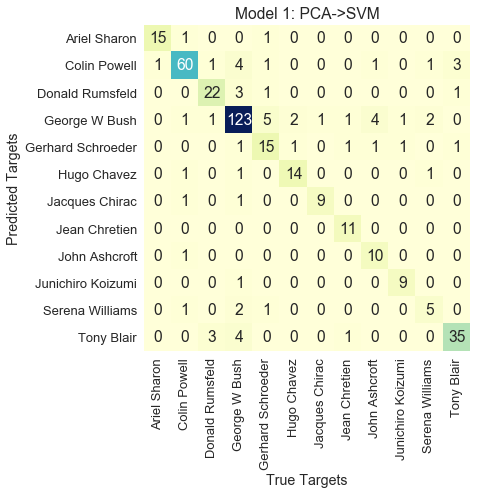

In [30]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.3)
sns.heatmap(mat_1.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="YlGnBu")
plt.title('Model 1: PCA->SVM')
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets');

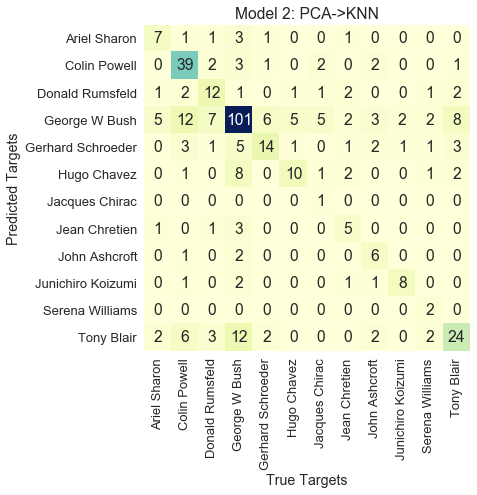

In [31]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.3)
sns.heatmap(mat_2.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="YlGnBu")
plt.title('Model 2: PCA->KNN')
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets');

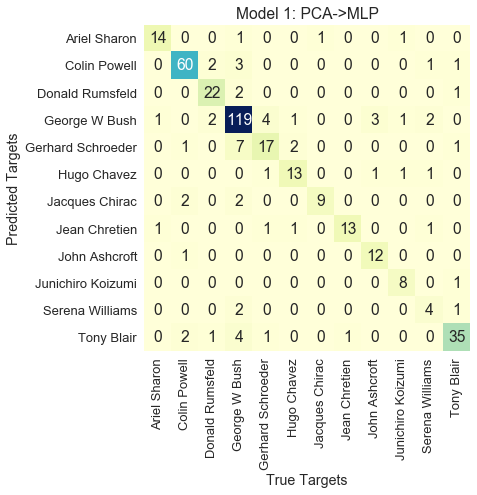

In [32]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.3)
sns.heatmap(mat_3.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="YlGnBu")
plt.title('Model 1: PCA->MLP')
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets');

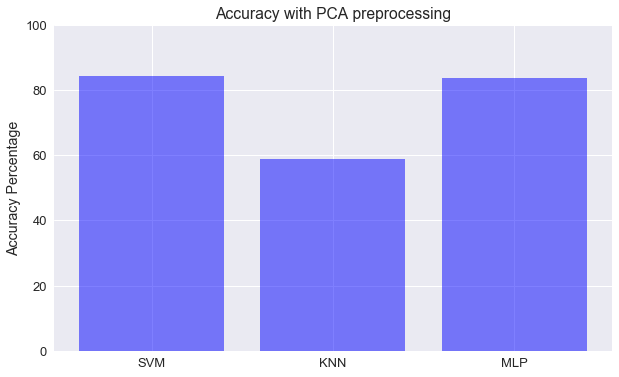

In [39]:
# plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 6))
pca_objects = ('SVM', 'KNN', 'MLP')
y_pos = np.arange(len(pca_objects))
pca_accuracy = [svc_accuracy, knn_accuracy, mlp_accuracy]

ax.bar(y_pos, pca_accuracy, align='center', alpha=0.5, tick_label=pca_objects, color='blue')
ax.set_ylabel('Accuracy Percentage')
ax.set_ylim(0, 100)
ax.set_title('Accuracy with PCA preprocessing')